In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import datetime
import io
import os
import random
from PIL import Image
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation,RandomContrast ,Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.train import Example, Features, Feature
from tensorflow.train import BytesList, FloatList, Int64List

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [68]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [69]:
train_directory = "train"
val_directory = "test"

In [70]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [71]:
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[ 89.      ,  89.      ,  89.      ],
         [ 91.4375  ,  91.4375  ,  91.4375  ],
         [ 85.8125  ,  85.8125  ,  85.8125  ],
         ...,
         [ 26.6875  ,  26.6875  ,  26.6875  ],
         [ 26.      ,  26.      ,  26.      ],
         [ 26.      ,  26.      ,  26.      ]],

        [[ 79.25    ,  79.25    ,  79.25    ],
         [ 86.30859 ,  86.30859 ,  86.30859 ],
         [ 87.89453 ,  87.89453 ,  87.89453 ],
         ...,
         [ 25.875   ,  25.875   ,  25.875   ],
         [ 25.339844,  25.339844,  25.339844],
         [ 26.      ,  26.      ,  26.      ]],

        [[ 71.5     ,  71.5     ,  71.5     ],
         [ 79.625   ,  79.625   ,  79.625   ],
         [ 87.60156 ,  87.60156 ,  87.60156 ],
         ...,
         [ 24.570312,  24.570312,  24.570312],
         [ 23.253906,  23.253906,  23.253906],
         [ 24.625   ,  24.625   ,  24.625   ]],

        ...,

        [[170.      , 170.      ,

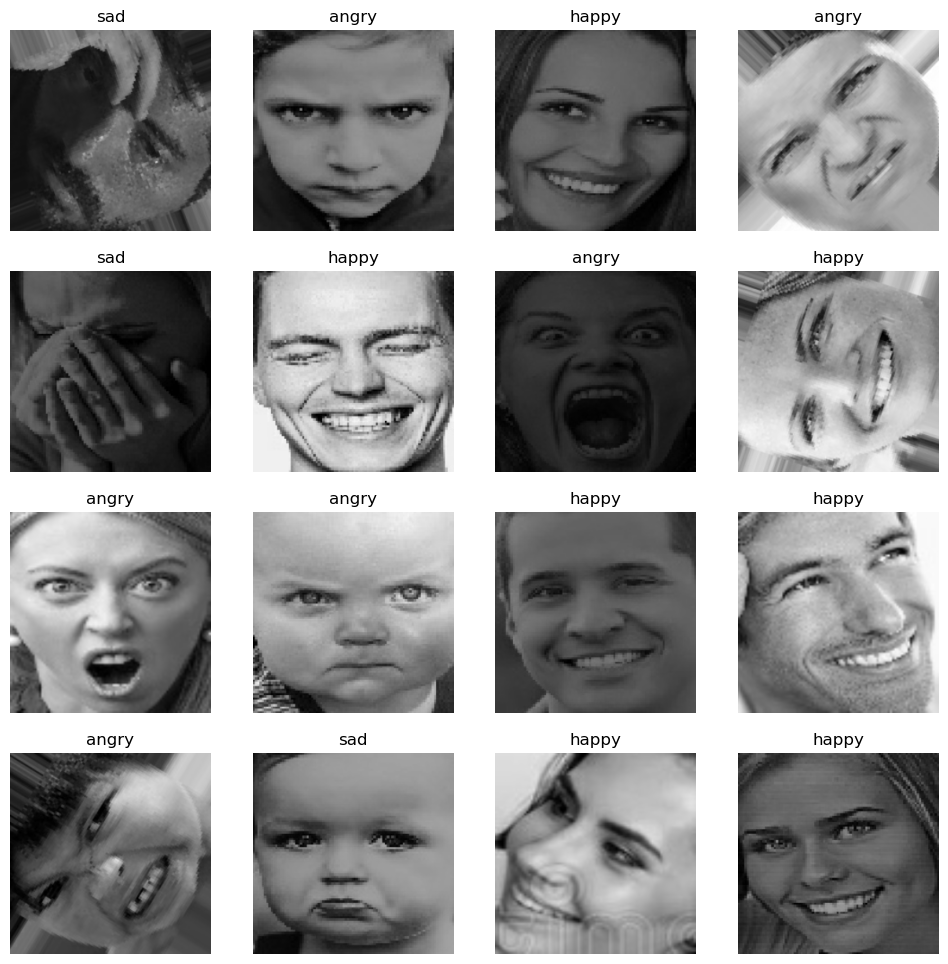

In [72]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
        plt.axis("off")

In [73]:
#prefetching to speed up loading data
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [74]:
## resize the images inside the model
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),                 
])

In [12]:
# creating a lenet model
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

In [13]:
# defining loss functions
loss_function = CategoricalCrossentropy() 

In [14]:
# defining metrics
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [15]:
# compiling the model
lenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [85]:
# using callbacks to optimize
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0, 
    patience=2,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False)

log_dir = "logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch ='0,20')

In [86]:
## Tensorboard
#METRIC_DIR = 'logs/ ' + CURRENT_TIME + '/metrics'
#train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [87]:
history = lenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = 2,
  verbose = 1,callbacks=[early,tensorboard_callback])

Epoch 1/2
213/213 [==============================] - 54s 254ms/step - loss: 0.3245 - accuracy: 0.8837 - top_k_accuracy: 0.9747 - val_loss: 0.8673 - val_accuracy: 0.6888 - val_top_k_accuracy: 0.8854
Epoch 2/2
213/213 [==============================] - 50s 233ms/step - loss: 0.2232 - accuracy: 0.9250 - top_k_accuracy: 0.9882 - val_loss: 0.9717 - val_accuracy: 0.7107 - val_top_k_accuracy: 0.8876


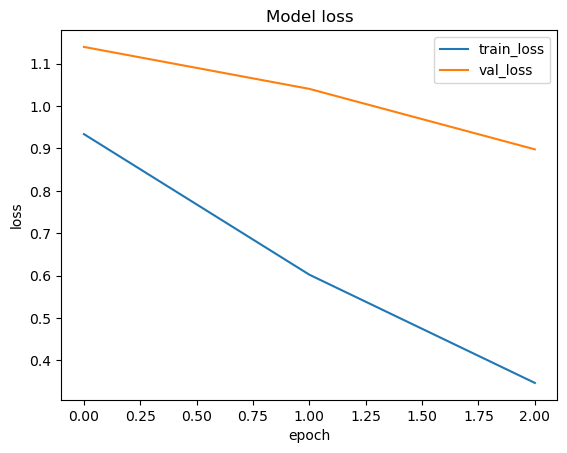

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

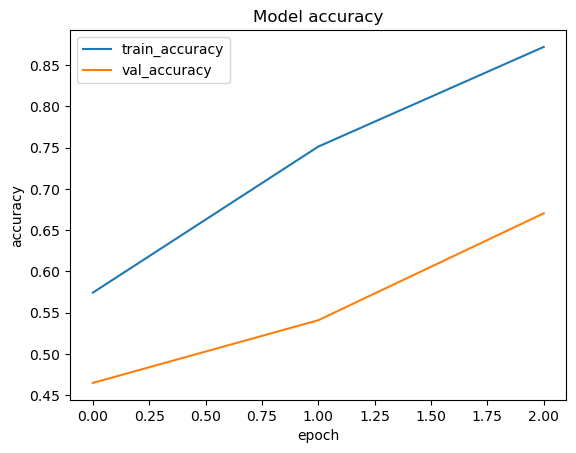

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [18]:
lenet_model.evaluate(validation_dataset)

2278/2278 [==============================] - 7s 3ms/step - loss: 0.8980 - accuracy: 0.6703 - top_k_accuracy: 0.8863


[0.8980013728141785, 0.6703248620033264, 0.8863037824630737]

In [20]:
predicted = []
labels = []

for im, label in validation_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())

In [21]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 1 1 ... 0 1 1]
[1 2 1 ... 2 1 1]


In [22]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[230 168 117]
 [ 26 863 117]
 [ 60 263 434]]


Text(0.5, 14.722222222222216, 'Predicted')

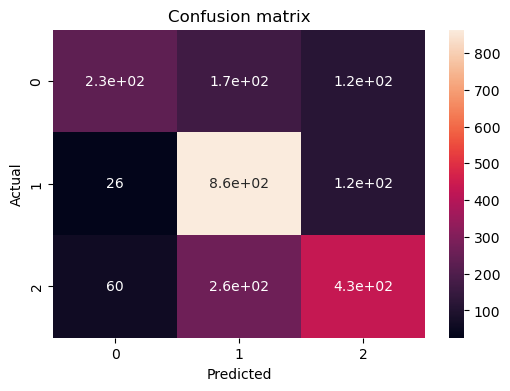

In [23]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(6,4))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [24]:
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),                   
])

In [25]:
def augment_layer(image, label):
    return augment_layers(image, training = True), label

In [26]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [27]:
# train the model again
aug = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

aug.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 254, 254, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 6)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

In [28]:
aug.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [49]:
history = lenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1)

213/213 [==============================] - 21s 91ms/step - loss: 0.2021 - accuracy: 0.9285 - top_k_accuracy: 0.9879 - val_loss: 0.9555 - val_accuracy: 0.7076 - val_top_k_accuracy: 0.9030


### TF Records - Efficient pipeline - help store data effieciently and parallelization
### advantages - 
**store the augmented data so no need to carry out everytime

**store in one big file than lot of small files

** tf records store protocol buffers

** parallelize reading data like  - each host has 10-100 Mbs of data
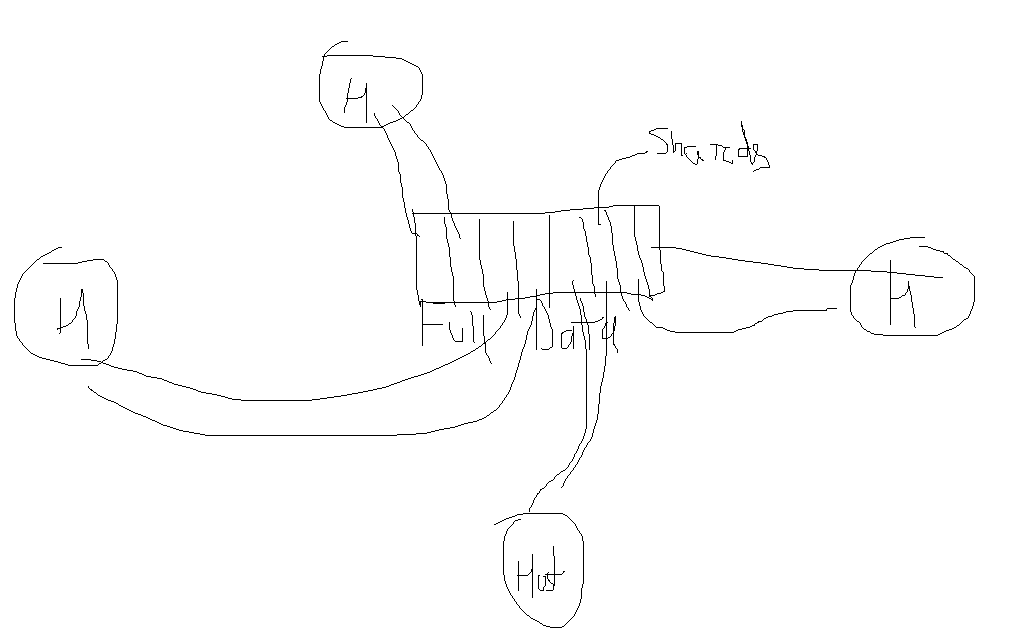

In [53]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    #.prefetch(tf.data.AUTOTUNE)
)

train_dataset = (
    training_dataset
    .unbatch()
)

val_dataset = (
    validation_dataset
    .unbatch()
)

In [58]:
# create proto files format
def create_example(image, label):
    
    bytes_feature = Feature(bytes_list=BytesList(value=[image]))
    int_feature = Feature(int64_list=Int64List(value=[label]))
    
    example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))
    return example.SerializeToString()

In [67]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [68]:
# convert images from jpeg to bytes because feature of image is byte in proto file format
def encode_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8) # convert into unsigned int from float
    image = tf.io.encode_jpeg(image)
    return image,tf.argmax(label) 

In [69]:
encoded_dataset = (
  train_dataset
  .map(encode_image)
)

In [74]:
for shard_number in range(NUM_SHARDS):
    sharded_dataset = (encoded_dataset.shard(NUM_SHARDS, shard_number).as_numpy_iterator())
    with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
        for encoded_image, encoded_label in sharded_dataset:
            example = create_example(encoded_image, encoded_label)
            file_writer.write(example)

In [75]:
# get all file names to reconstruct data
recons_dataset = tf.data.TFRecordDataset(filenames =[PATH.format(p) for p in range(NUM_SHARDS)] )

In [76]:
def parse_tfrecords(example):
  
    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }
    
    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(tf.io.decode_jpeg(example["images"], channels = 3), 
                                                     dtype = tf.float32) ## decode image

    return example["images"], example["labels"]
    

In [77]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)


In [78]:
parsed_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [79]:
for i in parsed_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[0.41176474, 0.41176474, 0.41176474],
         [0.7176471 , 0.7176471 , 0.7176471 ],
         [0.96470594, 0.96470594, 0.96470594],
         ...,
         [0.0509804 , 0.0509804 , 0.0509804 ],
         [0.6627451 , 0.6627451 , 0.6627451 ],
         [0.9803922 , 0.9803922 , 0.9803922 ]],

        [[0.8431373 , 0.8431373 , 0.8431373 ],
         [0.8431373 , 0.8431373 , 0.8431373 ],
         [0.8980393 , 0.8980393 , 0.8980393 ],
         ...,
         [0.86666673, 0.86666673, 0.86666673],
         [0.0627451 , 0.0627451 , 0.0627451 ],
         [0.5568628 , 0.5568628 , 0.5568628 ]],

        [[1.        , 1.        , 1.        ],
         [0.80392164, 0.80392164, 0.80392164],
         [0.76470596, 0.76470596, 0.76470596],
         ...,
         [0.7725491 , 0.7725491 , 0.7725491 ],
         [0.16862746, 0.16862746, 0.16862746],
         [0.0627451 , 0.0627451 , 0.0627451 ]],

        ...,

        [[0.31764707, 0.31764707

In [80]:
# create model again
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_8 (Batc  (None, 254, 254, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 6)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 16)     

In [81]:
loss_function = SparseCategoricalCrossentropy()

metrics = [SparseCategoricalAccuracy(name = "accuracy")]

lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics,)


In [82]:
history = lenet_model.fit(
    parsed_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    )

Epoch 1/3
213/213 [==============================] - 11s 44ms/step - loss: 1.1842 - accuracy: 0.4215
Epoch 2/3
213/213 [==============================] - 8s 38ms/step - loss: 0.3429 - accuracy: 0.8953
Epoch 3/3
213/213 [==============================] - 8s 38ms/step - loss: 0.1737 - accuracy: 0.9431


## hyper parameter tuning

In [107]:
#IM_SIZE = 224
def model_tune(hparams):
    lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = hparams[HP_DROPOUT] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense(hparams[HP_NUM_UNITS_1], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    Dropout(rate = hparams[HP_DROPOUT]),
    
    Dense(hparams[HP_NUM_UNITS_1], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),
    ])
    
    lenet_model.compile(
        optimizer= Adam(learning_rate = hparams[HP_LEARNING_RATE]),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    lenet_model.fit(validation_dataset, epochs=1)
    _, accuracy = lenet_model.evaluate(validation_dataset)

    return accuracy

In [108]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16,32,64,128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16,32,64,128]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.Discrete([0.1,0.2,0.3]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.001,0.01,0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))

In [109]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
    for num_units_2 in HP_NUM_UNITS_2.domain.values:
        for dropout_rate in HP_DROPOUT.domain.values:
            for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
                for learning_rate in HP_LEARNING_RATE.domain.values:
                    hparams = {
                          HP_NUM_UNITS_1: num_units_1,
                          HP_NUM_UNITS_2: num_units_2,
                          HP_DROPOUT: dropout_rate,
                          HP_REGULARIZATION_RATE: regularization_rate,
                          HP_LEARNING_RATE: learning_rate
                                          }
                    file_writer = tf.summary.create_file_writer('logs/hparams-' + str(run_number))

                    with file_writer.as_default():
                        hp.hparams(hparams)
                        accuracy = model_tune(hparams)
                        tf.summary.scalar('accuracy', accuracy, step = 0)
                    print("For the run {}, hparams num_units_1:{}, num_units_2:{}, dropout:{}, regularization_rate:{}, learning_rate:{}".format(run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2],
                                                             hparams[HP_DROPOUT], hparams[HP_REGULARIZATION_RATE],
                                                             hparams[HP_LEARNING_RATE]))
                    run_number += 1

2278/2278 [==============================] - 6s 3ms/step - loss: 0.6423 - accuracy: 0.4416
For the run 0, hparams num_units_1:16, num_units_2:16, dropout:0.1, regularization_rate:0.001, learning_rate:0.0001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6191 - accuracy: 0.4416
For the run 1, hparams num_units_1:16, num_units_2:16, dropout:0.1, regularization_rate:0.001, learning_rate:0.001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6693 - accuracy: 0.4416
For the run 2, hparams num_units_1:16, num_units_2:16, dropout:0.1, regularization_rate:0.01, learning_rate:0.0001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6192 - accuracy: 0.4416
For the run 3, hparams num_units_1:16, num_units_2:16, dropout:0.1, regularization_rate:0.01, learning_rate:0.001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.9552 - accuracy: 0.4416
For the run 4, hparams num_units_1:16, num_units_2:16, dropout:0.1, regularization_ra

2278/2278 [==============================] - 6s 3ms/step - loss: 0.6193 - accuracy: 0.4416
For the run 55, hparams num_units_1:16, num_units_2:128, dropout:0.1, regularization_rate:0.001, learning_rate:0.001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6608 - accuracy: 0.4416
For the run 56, hparams num_units_1:16, num_units_2:128, dropout:0.1, regularization_rate:0.01, learning_rate:0.0001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6192 - accuracy: 0.4416
For the run 57, hparams num_units_1:16, num_units_2:128, dropout:0.1, regularization_rate:0.01, learning_rate:0.001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.9146 - accuracy: 0.4416
For the run 58, hparams num_units_1:16, num_units_2:128, dropout:0.1, regularization_rate:0.1, learning_rate:0.0001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6191 - accuracy: 0.4416
For the run 59, hparams num_units_1:16, num_units_2:128, dropout:0.1, regulariz

2278/2278 [==============================] - 6s 2ms/step - loss: 0.6529 - accuracy: 0.4416
For the run 110, hparams num_units_1:32, num_units_2:64, dropout:0.1, regularization_rate:0.01, learning_rate:0.0001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6192 - accuracy: 0.4416
For the run 111, hparams num_units_1:32, num_units_2:64, dropout:0.1, regularization_rate:0.01, learning_rate:0.001
2278/2278 [==============================] - 6s 2ms/step - loss: 0.8881 - accuracy: 0.4416
For the run 112, hparams num_units_1:32, num_units_2:64, dropout:0.1, regularization_rate:0.1, learning_rate:0.0001
2278/2278 [==============================] - 6s 2ms/step - loss: 0.6195 - accuracy: 0.4416
For the run 113, hparams num_units_1:32, num_units_2:64, dropout:0.1, regularization_rate:0.1, learning_rate:0.001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6262 - accuracy: 0.4416
For the run 114, hparams num_units_1:32, num_units_2:64, dropout:0.2, regularizat

2278/2278 [==============================] - 6s 3ms/step - loss: 0.6194 - accuracy: 0.4416
For the run 165, hparams num_units_1:64, num_units_2:32, dropout:0.1, regularization_rate:0.01, learning_rate:0.001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.7570 - accuracy: 0.4416
For the run 166, hparams num_units_1:64, num_units_2:32, dropout:0.1, regularization_rate:0.1, learning_rate:0.0001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6194 - accuracy: 0.4416
For the run 167, hparams num_units_1:64, num_units_2:32, dropout:0.1, regularization_rate:0.1, learning_rate:0.001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6222 - accuracy: 0.4416
For the run 168, hparams num_units_1:64, num_units_2:32, dropout:0.2, regularization_rate:0.001, learning_rate:0.0001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6194 - accuracy: 0.4416
For the run 169, hparams num_units_1:64, num_units_2:32, dropout:0.2, regulariza

2278/2278 [==============================] - 6s 3ms/step - loss: 0.6194 - accuracy: 0.4416
For the run 219, hparams num_units_1:128, num_units_2:16, dropout:0.1, regularization_rate:0.01, learning_rate:0.001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6599 - accuracy: 0.4416
For the run 220, hparams num_units_1:128, num_units_2:16, dropout:0.1, regularization_rate:0.1, learning_rate:0.0001
2278/2278 [==============================] - 6s 2ms/step - loss: 0.6197 - accuracy: 0.4416
For the run 221, hparams num_units_1:128, num_units_2:16, dropout:0.1, regularization_rate:0.1, learning_rate:0.001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6196 - accuracy: 0.4416
For the run 222, hparams num_units_1:128, num_units_2:16, dropout:0.2, regularization_rate:0.001, learning_rate:0.0001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6193 - accuracy: 0.4416
For the run 223, hparams num_units_1:128, num_units_2:16, dropout:0.2, regul

2278/2278 [==============================] - 6s 3ms/step - loss: 0.6193 - accuracy: 0.4416
For the run 273, hparams num_units_1:128, num_units_2:128, dropout:0.1, regularization_rate:0.01, learning_rate:0.001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6670 - accuracy: 0.4416
For the run 274, hparams num_units_1:128, num_units_2:128, dropout:0.1, regularization_rate:0.1, learning_rate:0.0001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6192 - accuracy: 0.4416
For the run 275, hparams num_units_1:128, num_units_2:128, dropout:0.1, regularization_rate:0.1, learning_rate:0.001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6196 - accuracy: 0.4416
For the run 276, hparams num_units_1:128, num_units_2:128, dropout:0.2, regularization_rate:0.001, learning_rate:0.0001
2278/2278 [==============================] - 6s 3ms/step - loss: 0.6193 - accuracy: 0.4416
For the run 277, hparams num_units_1:128, num_units_2:128, dropout:0.2, 